# Stock Market Data Analysis with Python

**Basics for handling and analyzing stock market data**

## 1. Getting Stock Data
Getting Data from **[Quandl](https://github.com/quandl/quandl-python)**. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import seaborn as sns
from fbprophet import Prophet

sns.set_context("notebook")

In [2]:
# https://docs.quandl.com/v1.0/docs/python-installation#section-authentication
tata_steel = quandl.get("NSE/TATASTEEL", authtoken="HALLO")

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/quandl/get.py:91: DeprecationWarning: authtoken will no longer supported. Please use api_key instead
  warnings.warn(msg, DeprecationWarning)


In [3]:
tata_steel.shape

(3159, 7)

In [4]:
tata_steel.head(3)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2005-10-17,380.00,386.30,374.6,384.2,384.35,4618966.0,17639.41
2005-10-18,386.85,388.55,364.1,365.1,374.85,3408087.0,13024.16
2005-10-19,371.60,373.55,352.0,362.7,361.55,4549667.0,16641.13


In [5]:
tata_steel.tail(3)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-07-06,550.0,564.25,546.35,553.35,553.50,6614783.0,36841.56
2018-07-09,563.7,565.75,554.75,555.30,555.60,7443751.0,41641.40
2018-07-10,559.0,571.00,556.90,569.00,568.65,10004905.0,56592.24


In [6]:
tata_steel.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3159.0,4.757847e+02,1.572201e+02,137.50,368.825,464.25,582.400,997.30
High,3159.0,4.839193e+02,1.600393e+02,150.40,373.925,471.80,591.200,1048.00
Low,3159.0,4.665471e+02,1.538305e+02,137.50,362.100,454.35,572.225,966.25
Last,3159.0,4.747627e+02,1.568022e+02,148.90,366.800,462.20,580.100,993.00
Close,3159.0,4.748824e+02,1.568091e+02,148.80,367.425,462.30,580.525,988.90
Total Trade Quantity,3159.0,5.457051e+06,3.390836e+06,66051.00,3196472.500,4682270.00,6816801.000,49407351.00
Turnover (Lacs),3159.0,2.444331e+04,1.579906e+04,207.05,13969.405,19943.13,30016.230,240287.82


## 2. Visualizing Stock Data

### Plot the Daily Closing Price and Volume of a Stock

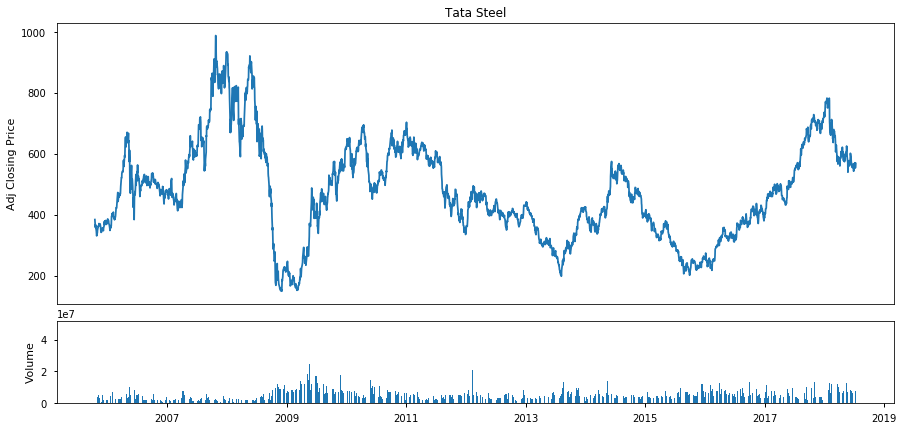

In [7]:
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(tata_steel.index, tata_steel['Close']) 
bottom.bar(tata_steel.index, tata_steel['Total Trade Quantity']) 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title('Tata Steel')
top.set_ylabel('Adj Closing Price')
bottom.set_ylabel('Volume');

### Plot a Histogram of the Daily Closing Price

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


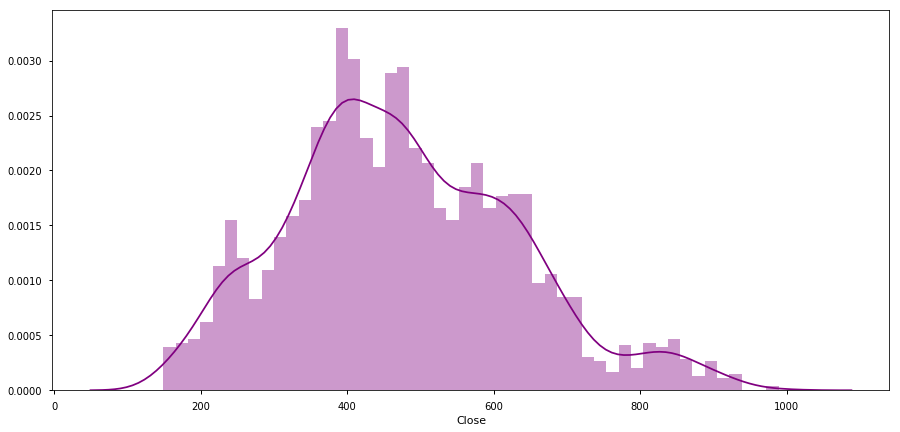

In [8]:
plt.figure(figsize=(15,7))
sns.distplot(tata_steel['Close'].dropna(), bins=50, color='purple');

### Chart using Simple Moving Average

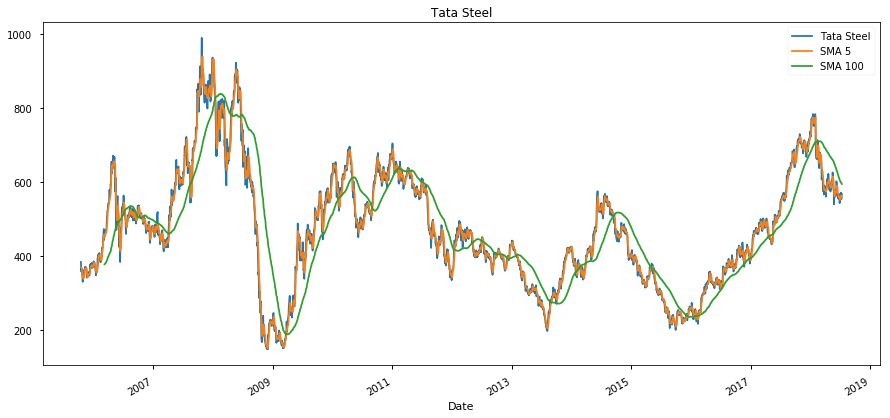

In [9]:
# simple moving averages
sma5 = tata_steel['Close'].rolling(5).mean() #5 days
sma100 = tata_steel['Close'].rolling(100).mean() #100 days
 
tata_steel_sma = pd.DataFrame({'Tata Steel': tata_steel['Close'], 'SMA 5': sma5, 'SMA 100': sma100})
tata_steel_sma.plot(figsize=(15, 7), legend=True, title='Tata Steel');

# 3. Time series forecasting with [`prophet`](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Forecasting daily `Close`

In [10]:
df = pd.DataFrame(tata_steel['Close'].copy())
df = df.reset_index()
df.columns = ['ds', 'y']

df['y'] = np.log1p(df.y)
df.head(10)

,ds,y
0,2005-10-17,5.954152
1,2005-10-18,5.929190
2,2005-10-19,5.893162
3,2005-10-20,5.884992
4,2005-10-21,5.909169
5,2005-10-24,5.867318
6,2005-10-25,5.862210
7,2005-10-26,5.851915
8,2005-10-27,5.824819
9,2005-10-28,5.804532


In [11]:
# Deleteing data for 2009 year
df.loc[(df['ds'] > '2009-01-01') & (df['ds'] < '2010-01-01'), 'y'] = None

In [12]:
%%time

m = Prophet(changepoint_prior_scale=0.001, yearly_seasonality=20, seasonality_mode='multiplicative',
           interval_width=0.8) #, mcmc_samples=300
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='quarterly', period=91.25, fourier_order=8)

m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


CPU times: user 1.46 s, sys: 35 ms, total: 1.5 s
Wall time: 1.49 s


In [13]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3519,2019-07-06
3520,2019-07-07
3521,2019-07-08
3522,2019-07-09
3523,2019-07-10


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3519,2019-07-06,6.055796,5.677487,6.470675
3520,2019-07-07,6.028096,5.669569,6.418726
3521,2019-07-08,6.215989,5.857914,6.596284
3522,2019-07-09,6.208125,5.817760,6.552496
3523,2019-07-10,6.198737,5.811784,6.585089


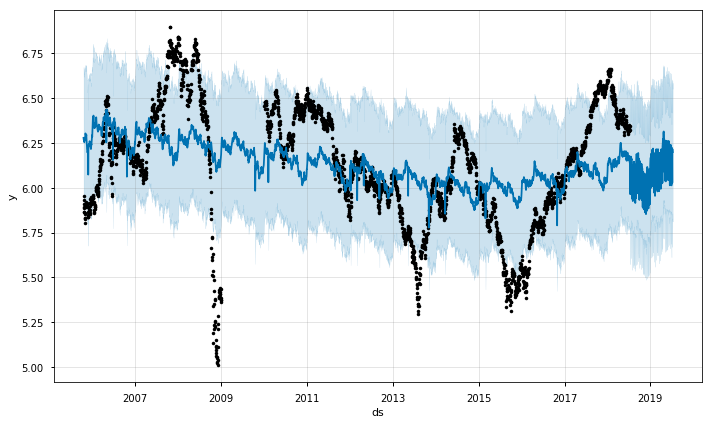

In [15]:
fig1 = m.plot(forecast)

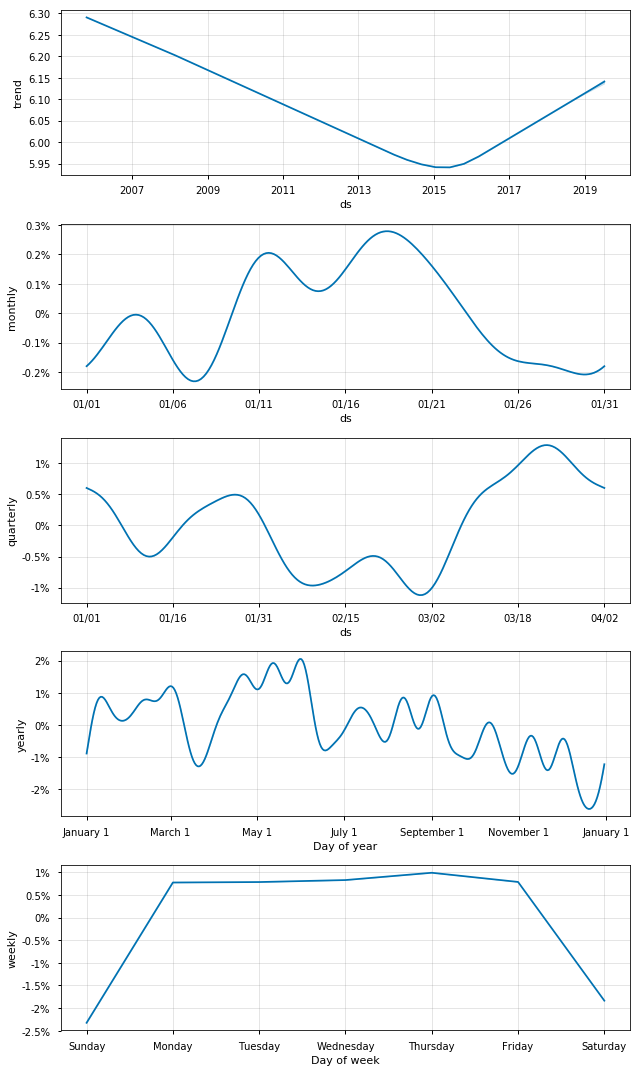

In [16]:
fig2 = m.plot_components(forecast)

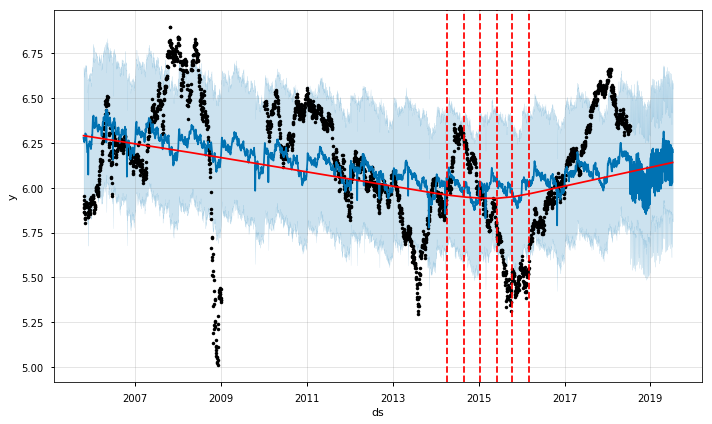

In [17]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

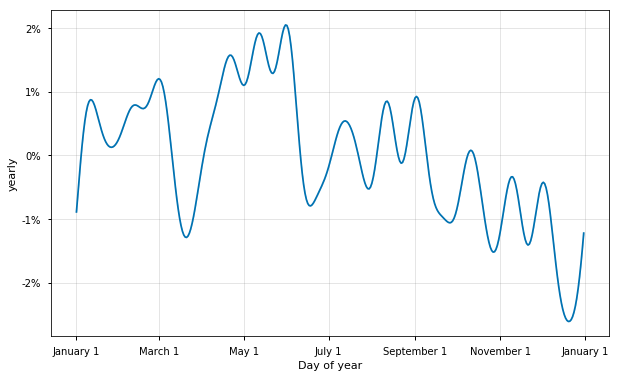

In [18]:
from fbprophet.plot import plot_yearly
a = plot_yearly(m)